In [1]:
import copy
import random
import math
import numpy as np
import pandas as pd
import time
import re
import os


app_map = [(re.compile(r'cootek\.smartinput\.(international|mainland)\.(ios|android).*'), 'keyboard')]
plugin_map = [(re.compile(r'(cootek\.smartinput\.android|com\.cootek\.smartinputv5)\.skin\..*'), 'skin'),
              (re.compile(r'(cootek\.smartinput.android|com\.cootek\.smartinputv5)\.language.*'), 'language'),
              (re.compile(r'(cootek\.smartinput\.android|com\.cootek\.smartinputv5)\.font.*'), 'font'),
              (re.compile(r'(cootek\.smartinput\.android|com\.cootek\.smartinputv5)\.emoji.*'), 'emoji'),
              (re.compile(r'cootek.smartinput.android.*touchpal.emoji.*'), 'emoji'),
              (re.compile(r'(cootek\.smartinput\.android|com\.cootek\.smartinputv5)\.sticker.*'), 'sticker'),
              (re.compile(r'(cootek\.smartinput\.android|com\.cootek\.smartinputv5)\.celldict.*'), 'celldict'),
              (re.compile(r'com.cootek.smartinputv5.boomtextv2.*'), 'boomtext')]
matrix_plugin_map = [
    (re.compile(r'com\.color\.call\.flash\.colorphone\.theme\..*'), 'com.color.call.flash.colorphone.theme')]
regex_map = app_map + plugin_map + matrix_plugin_map


def app_name2bundle(app_name):
    if not app_name:
        return app_name
    for (k, v) in regex_map:
        if k.search(app_name):
            return v
    return app_name


def preprocessing_data(forecast, real, target, attributions):
    forecast['app_name'] = forecast['app_name'].map(app_name2bundle)
    real['app_name'] = real['app_name'].map(app_name2bundle)
    forecast = forecast['impression'].groupby \
        (by=[forecast.app_name, forecast.country, forecast.id_type, forecast.platform, forecast.tu]).sum().reset_index()
    forecast = forecast.replace(['none', ''], np.nan).dropna().reset_index(drop=True)  # drop nan
    forecast.tu = forecast.tu.astype(int)
    real = real['impression'].groupby \
        (by=[real.app_name, real.country, real.id_type, real.platform, real.tu]).sum().reset_index()
    real = real.replace(['none', ''], np.nan).dropna().reset_index(drop=True)  # drop nan
    real.tu = real.tu.astype(int)
    temp = pd.concat([forecast, real])
#     real = temp[temp[attributions].duplicated(keep='first')]
    real = temp['impression'].groupby \
        (by=[temp.app_name, temp.country, temp.id_type, temp.platform, temp.tu]).min().reset_index()
    return forecast, real


def printCause(root_cause, ps_score):
    print('****************************************************************')
    print('----------------------------------------------------------------')
    for x, y in root_cause.items():
        print(str(x) + ':', end='')
        for i in range(len(y)):
            if i == 0:
                print(' ' * (10 - len(x)) + str(y[i]))
            else:
                print(' ' * 11 + str(y[i]))
        if len(y) == 0:
            print()
        print('----------------------------------------------------------------')

    print('ps score is {0:.2f}'.format(ps_score))
    print('****************************************************************')

def groupToOthers(forecast, real, topK):
    for attr in ['app_name', 'country', 'id_type', 'platform', 'tu']:
        rank = forecast['impression'].groupby(forecast[attr]).sum().sort_values(ascending=False).reset_index()
        mask_forecast = ~forecast[attr].isin(list(rank[0:topK][attr]))
        mask_real = ~real[attr].isin(list(rank[0:topK][attr]))
        if attr != 'tu':
            forecast.loc[mask_forecast, attr] = 'other '+attr
            real.loc[mask_real, attr] = 'other '+attr
        else:
            forecast.loc[mask_forecast, attr] = 0
            real.loc[mask_real, attr] = 0
    forecast = forecast.groupby(by=['app_name','country','id_type','platform','tu']).sum().reset_index()
    real = real.groupby(by=['app_name','country','id_type','platform','tu']).sum().reset_index()
    print(len(forecast))
    return forecast, real

def main(forecast, real, iterations=20, threshold=0.7, topK=10):
    from itertools import combinations
    forecast, real = groupToOthers(forecast, real, topK)
    choice = {'app_name': list(forecast['app_name'].unique()),
              'country': list(forecast['country'].unique()),
              'id_type': list(forecast['id_type'].unique()),
              'platform': list(forecast['platform'].unique()),
              'tu': list(forecast['tu'].unique())}
    print(choice)
    cur_available_choice = {'app_name': [],
                            'country': [],
                            'id_type': [],
                            'platform': [],
                            'tu': []}
    prev_available_choice = {'app_name': [],
                             'country': [],
                             'id_type': [],
                             'platform': [],
                             'tu': []}
    layers_number = len(choice)
    root_cause_list = []
    atrributions = list(choice.keys())
    for ln in range(1, layers_number + 1):
        for ch in combinations(atrributions, ln):
            cur_choice = {'app_name': [],
                          'country': [],
                          'id_type': [],
                          'platform': [],
                          'tu': []}
            if ln == 1:
                for c in ch:
                    cur_choice[c] = choice[c]
            else:
                for c in ch:
                    cur_choice[c] = prev_available_choice[c]
            mcts = MCTS(forecast=forecast, real=real, choice=cur_choice, iterations=iterations, threshold=threshold)
            start = time.time()
            best_node = mcts.get_result()
            end = time.time()
            print('costs {0:2f}s in layer {1}'.format(end - start, ln))
            root_cause_list.append([best_node.state, best_node.Q])
            for c in ch:
                cur_available_choice[c] = list(set(cur_available_choice[c]) | set(best_node.state[c]))
            printCause(best_node.state,best_node.Q)
            # print(best_node.state)
            # print(best_node.Q)


        prev_available_choice = cur_available_choice
        cur_available_choice = {'app_name': [],
                                'country': [],
                                'id_type': [],
                                'platform': [],
                                'tu': []}
    root_cause_list = sorted(root_cause_list, key= lambda x: -x[1])
    print('The most potential root cause is')
    printCause(root_cause_list[0][0], root_cause_list[0][1])
    return root_cause_list


def entry(forecast, root_cause):
    real = copy.deepcopy(forecast)
    mask = pd.Series([True]*len(real))
    for attr in root_cause:
        mask_inner = pd.Series([False]*len(real))
        for val in root_cause[attr]:
            mask_inner = mask_inner | pd.Series(real[attr] == val)
        if len(root_cause[attr])>0:
            mask = mask & mask_inner
    real = real.join(pd.DataFrame({'mask': mask}))
    real.loc[real['mask'] == True, 'impression'] = real.loc[real['mask'] == True, 'impression'] / 2
    real = real.reset_index(drop=True)
    real.drop(columns=['mask'], inplace=True)
    forecast, real = preprocessing_data(forecast, real, target='impression',
                                        attributions=['app_name', 'country', 'id_type', 'platform', 'tu'])
    root_cause_list = main(forecast, real, iterations=100, threshold=0.95, topK = 10)
    return root_cause_list[0]

In [2]:
class Node(object):
    # node类初始化
    def __init__(self):
        self.parents = None
        self.children = []
        self.state = {'app_name': [],
                      'country': [],
                      'id_type': [],
                      'platform': [],
                      'tu': []}  # 需要输入一个类别的空dict

        self.Q = 0
        self.N = 0


class MCTS(object):

    def __init__(self, forecast, real, choice,
                 iterations=5000,
                 threshold=0.7,  # set to 1 means return the best node in all iterations
                 target='impression'):
        self.forecast = forecast
        self.real = real
        self.choice = choice
        self.iterations = iterations
        self.threshold = threshold
        self.target = target

    def get_scores(self, root_cause, forecast, real):
        # forecast, and real should be in pandas' dataframe
        f = copy.deepcopy(forecast)
        total_h = (forecast.set_index(['app_name', 'country', 'id_type', 'platform', 'tu'])\
                   - real.set_index(['app_name', 'country', 'id_type', 'platform', 'tu'])).dropna(axis=0)\
                   [self.target].apply(lambda x:x**2).sum()
        if total_h == 0:
            raise Exception("Total KPI does not change!")
        f_sum, r_sum = 0, 0
        #         for cause in root_cause.items():
        #             if cause[1] != []:
        #                 f_sum += f[f[cause[0]].isin(cause[1])][self.target].sum()
        #                 r_sum += real[real[cause[0]].isin(cause[1])][self.target].sum()
        mask_f = pd.Series([True] * len(f))
        mask_r = pd.Series([True] * len(real))
        for cause in root_cause.items():
            if cause[1] != []:
                mask_f = mask_f & f[cause[0]].isin(cause[1])
                mask_r = mask_r & real[cause[0]].isin(cause[1])
        f_sum = f.loc[mask_f][self.target].sum()
        r_sum = real.loc[mask_r][self.target].sum()

        # modified reppile effect.
        h = f_sum - r_sum
        if h == 0:  # under the given root cause, kpi does not change
            return 0
        mask = pd.Series([True] * len(f))
        for cause in root_cause.items():
            if cause[1] != []:
                mask = mask & f[cause[0]].isin(cause[1])
        f = f.join(pd.DataFrame({'mask': mask}))
        f.loc[f['mask'] == True, self.target] = f.loc[f['mask'] == True, self.target] * (1 - h/ f_sum)
        f.drop(columns=['mask'], inplace =True)
        temp = (f.set_index(['app_name', 'country', 'id_type', 'platform', 'tu'])\
                   - real.set_index(['app_name', 'country', 'id_type', 'platform', 'tu'])).dropna(axis=0)\
                   [self.target].apply(lambda x:x**2).sum()
        ps = 1 - np.sqrt(temp / total_h)
        return max(ps, 0)
    
    def init_children(self, node, choice):
        for e in choice.items():
            key, value = e[0], e[1]
            for i in e[1]:
                if i not in node.state[e[0]]:
                    Child = Node()
                    Child.state = copy.deepcopy(node.state)
                    Child.parents = node
                    node.children.append(Child)
                    Child.state[e[0]].append(i)
                    Child.Q = self.get_scores(Child.state, self.forecast, self.real)

    def count_number_of_state(self, state_dict):
        count = 0
        for key in state_dict.keys():
            count += len(state_dict[key])
        return count

    def selection(self, node, choice):
        all_selected = False
        # 当前节点不含所有元素
        while self.count_number_of_state(node.state) < self.count_number_of_state(choice):
            # 第一次访问新节点，初始化它的孩子节点
            if len(node.children) == 0:
                self.init_children(node, choice)  # 如果新的点，Q_max=0，一定返回随机选取的一个点
            # 如果当前节点存在没有访问过的孩子节点，则依据概率选择深度优先还是广度优先
            Q_max = 0
            is_random = False
            for i in node.children:
                if i.Q > Q_max and i.N > 0:
                    Q_max = i.Q
                if i.N == 0:
                    is_random = True

            if is_random:
                if random.random() > Q_max:
                    return node, all_selected

            # 否则依据UCB公式计算最优的孩子节点，重复这个过程
            node = self.best_child(node)

        # 当前节点包含所有元素，不再搜索并返回
        all_selected = True
        return node, all_selected

    def best_child(self, node):
        # 依据UCB公式计算最优孩子节点
        best_score = -1
        best = None

        for sub_node in node.children:

            # 在可选的节点里面选择最优
            if sub_node.N > 0:
                C = math.sqrt(2.0)
                left = sub_node.Q
                right = math.log(node.N) / sub_node.N
                score = left + C * math.sqrt(right)

                if score > best_score:
                    best = sub_node
                    best_score = score

        return best

    def expansion(self, selection_node):
        # 不用ucb，直接greedy取最大的Q
        if self.count_number_of_state(selection_node.state) == \
                self.count_number_of_state(self.choice):  # leaf node
            return selection_node, True
        best_node = None
        best_Q = 0
        for i in selection_node.children:
            if i.Q >= best_Q and i.N == 0:
                best_Q = i.Q
                best_node = i
        if best_node == None:
            for i in selection_node.children:
                print(i.N)
        return best_node, False

    def evalation(self, selection_node):
        new_q = selection_node.Q
        selection_node.N += 1
        return new_q

    def backup(self, selection_node, new_q):
        node = selection_node.parents
        while node is not None:
            node.N += 1
            if new_q > node.Q:
                node.Q = new_q
            node = node.parents

    def get_best_node(self, node):
        # 获得最大Q值的所有节点中的最下层的节点
        best_score = node.Q
        while len(node.children) != 0:
            for index in range(len(node.children)):
                if node.children[index].Q == best_score:
                    node = node.children[index]
                    break
        return node

    def get_result(self):
        node = Node()
        max_q = -0.1
        best_node = None

        # 开始搜索，最大搜索次数可变
        for i in range(self.iterations):
            # print('Start {0} Iteration'.format(i))
            # 1、选择，如果所有节点搜索完毕，则跳出循环
            selection_node, all_selected = self.selection(node, self.choice)
            # if all_selected:
            #     break

            # 2、扩展，获得剩余元素中的最大元素值
            cur_best_node, flag = self.expansion(selection_node)
            if flag == True:
                continue

            # 3、评价，
            new_q = self.evalation(cur_best_node)

            # 4、更新，新状态节点至根节点路径中的每个节点：N+1，Q赋值为路径中最大Q值
            self.backup(cur_best_node, new_q)

            # 如果根节点Q值变大，则更新最优节点
            if node.Q > max_q:
                best_node = self.get_best_node(node)
                max_q = node.Q
                # print('current max ps score is {0}'.format(max_q))
            # 如果新节点的Q值超过预设阀值，则跳出循环
            if new_q >= self.threshold:
                break
        return best_node

In [6]:
with open('20190601.json') as f:
            forecast = pd.read_json(f, lines=True)

In [7]:
choice = {'app_name': list(forecast['impression'].groupby(forecast['app_name']).sum().sort_values(ascending = False)[0:5].index),
          'country': list(forecast['impression'].groupby(forecast['country']).sum().sort_values(ascending = False)[0:5].index),
          'id_type': list(forecast['impression'].groupby(forecast['id_type']).sum().sort_values(ascending = False)[0:5].index),
          'platform': list(forecast['impression'].groupby(forecast['platform']).sum().sort_values(ascending = False)[0:5].index),
          'tu': list(forecast['impression'].groupby(forecast['tu']).sum().sort_values(ascending = False)[0:5].index)}

In [3]:
import random
from itertools import combinations

In [82]:
layers_number = 5
atrributions = ['app_name','country','id_type','platform','tu']
synthesis_root_cause = []
detect_root_cause = []
for _ in range(10):
    for ln in range(1, layers_number + 1):
        for ch in combinations(atrributions, ln):
            root_cause = {'app_name': [],
              'country': [],
              'id_type': [],
              'platform': [],
              'tu': []}
            for c in ch:
                root_cause[c] = random.sample(choice[c],2)
            # synthesize data
            with open('20190601.json') as f:
                forecast = pd.read_json(f, lines=True)
            real = copy.deepcopy(forecast)
            mask = pd.Series([True]*len(real))
            for attr in root_cause:
                mask_inner = pd.Series([False]*len(real))
                for val in root_cause[attr]:
                    mask_inner = mask_inner | pd.Series(real[attr] == val)
                if len(root_cause[attr])>0:
                    mask = mask & mask_inner
            real = real.join(pd.DataFrame({'mask': mask}))
            real.loc[real['mask'] == True, 'impression'] = real.loc[real['mask'] == True, 'impression'] / 2
            # preprossing data
            forecast, real = preprocessing_data(forecast, real, 'impression', ['app_name','country','id_type','platform','tu'])
            forecast, real = groupToOthers(forecast, real, 10)
            # search over all choice
            available_choice = {'app_name': list(forecast['app_name'].unique()),
                      'country': list(forecast['country'].unique()),
                      'id_type': list(forecast['id_type'].unique()),
                      'platform': list(forecast['platform'].unique()),
                      'tu': list(forecast['tu'].unique())}
            mcts = MCTS(forecast=forecast, real=real, choice=available_choice, iterations=200, threshold=0.85)
            try:
                best_node = mcts.get_result()
                 # store root cause
                synthesis_root_cause.append(root_cause)
                detect_root_cause.append(best_node)
            except:
                print('KPI does not change in this root cause, omit it!')

4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
KPI does not change in this root cause, omit it!
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
KPI does not change in this root cause, omit it!
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
KPI does not change in this root cause, omit it!
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
KPI does not change in this root cause, omit it!
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
4964
KPI does not change in this root cause, omit it!
4964


In [96]:
detect_root_cause[-1].state

{'app_name': [],
 'country': [],
 'id_type': [],
 'platform': ['flurry'],
 'tu': [661]}

In [98]:
synthesis_root_cause[-1]

{'app_name': ['cootek.smartinput.international.android.public',
  'com.color.call.flash.colorphone'],
 'country': ['IN', 'BR'],
 'id_type': ['native', 'interstitial'],
 'platform': ['mopub', 'flurry'],
 'tu': ['661', '2763']}

In [104]:
set_syn

{'2337',
 '2338',
 'admob',
 'adx',
 'com.color.call.flash.colorphone',
 'native',
 'search',
 'skin'}

In [83]:
res_dic = {'2':[],'4':[],'6':[],'8':[],'10':[]}
for i in range(len(synthesis_root_cause)-1):
    num = 0
    set_syn = set()
    set_dec = set()
    for item in synthesis_root_cause[i].values():
        num += len(item)
        set_syn = set_syn.union(set(map(str, item)))
    for item in detect_root_cause[i].state.values():
        set_dec = set_dec.union(set(map(str, item)))
    count = len(set_syn.intersection(set_dec))
    res_dic[str(num)].append(count)

In [88]:
mean_list = [np.mean(l)/int(num) for num,l in res_dic.items()]

[0.95, 0.7373737373737373, 0.5017182130584192, 0.3352272727272727, 0.2125]

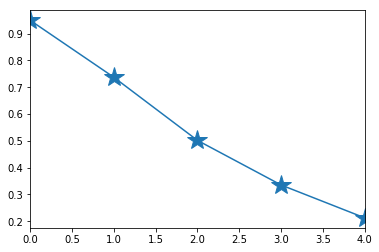

In [105]:
pd.Series(mean_list).plot(marker = '*', markersize = 20)
mean_list

In [ ]:
mask = pd.Series([True]*len(real))
for attr in root_cause:
    mask_inner = pd.Series([False]*len(real))
    for val in root_cause[attr]:
        mask_inner = mask_inner | pd.Series(real[attr] == val)
    if len(root_cause[attr])>0:
        mask = mask & mask_inner

In [63]:
np.sum(mask)

0

In [ ]:
count = []
for i in range(len(detect_root_cause)):
    synthesis_root_cause[i] detect_root_cause[i][0]:
        count += 1

In [ ]:
count / len(detect_root_cause)

In [ ]:
synthesis_root_cause[-1]

In [ ]:
synthesis_root_cause[0]

In [ ]:
root_cause = {'app_name': ['com.color.call.flash.colorphone.theme'],
 'country': ['US', 'MX'],
 'id_type': [],
 'platform': [],
 'tu': []}
real = copy.deepcopy(forecast)
mask = pd.Series([True]*len(real))
for attr in root_cause:
    mask_inner = pd.Series([False]*len(real))
    for val in root_cause[attr]:
        mask_inner = mask_inner | pd.Series(real[attr] == val)
    if len(root_cause[attr])>0:
        mask = mask & mask_inner
real = real.join(pd.DataFrame({'mask': mask}))
real.loc[real['mask'] == True, 'impression'] = real.loc[real['mask'] == True, 'impression'] / 2

In [ ]:
forecast, real = preprocessing_data(forecast, real, 'impression', ['app_name','country','id_type','platform','tu'])

In [ ]:
forecast, real = groupToOthers(forecast, real, 10)

In [62]:
forecast.impression.sum() - real.impression.sum()

0.0

In [ ]:
forecast[forecast['app_name'].isin(['com.color.call.flash.colorphone.theme'])][forecast['country'].isin(['US', 'MX'])].impression.sum() \
- real[real['app_name'].isin(['com.color.call.flash.colorphone.theme'])][real['country'].isin(['US', 'MX'])].impression.sum()

In [ ]:
choice = {'app_name': list(forecast['app_name'].unique()),
          'country': list(forecast['country'].unique()),
          'id_type': list(forecast['id_type'].unique()),
          'platform': list(forecast['platform'].unique()),
          'tu': list(forecast['tu'].unique())}

In [ ]:
get_scores({'app_name': ['com.color.call.flash.colorphone.theme'],
 'country': ['US', 'MX'],
 'id_type': [],
 'platform': [],
 'tu': []}, forecast, real)

In [ ]:
mcts = MCTS(forecast=forecast, real=real, choice=choice, iterations=200, threshold=0.85)
best_node = mcts.get_result()

In [ ]:
best_node.state

In [ ]:
def get_scores(root_cause, forecast, real):
        # forecast, and real should be in pandas' dataframe
        f = copy.deepcopy(forecast)
        total_h = (forecast.set_index(['app_name', 'country', 'id_type', 'platform', 'tu'])\
                   - real.set_index(['app_name', 'country', 'id_type', 'platform', 'tu'])).dropna(axis=0)\
                   ['impression'].apply(lambda x:x**2).sum()
        if total_h == 0:
            raise Exception("Total KPI does not change!")
        f_sum, r_sum = 0, 0
        #         for cause in root_cause.items():
        #             if cause[1] != []:
        #                 f_sum += f[f[cause[0]].isin(cause[1])][self.target].sum()
        #                 r_sum += real[real[cause[0]].isin(cause[1])][self.target].sum()
        mask_f = pd.Series([True] * len(f))
        mask_r = pd.Series([True] * len(real))
        for cause in root_cause.items():
            if cause[1] != []:
                mask_f = mask_f & f[cause[0]].isin(cause[1])
                mask_r = mask_r & real[cause[0]].isin(cause[1])
        f_sum = f.loc[mask_f]['impression'].sum()
        r_sum = real.loc[mask_r]['impression'].sum()

        # modified reppile effect.
        h = f_sum - r_sum
        if h == 0:  # under the given root cause, kpi does not change
            return 0
        mask = pd.Series([True] * len(f))
        for cause in root_cause.items():
            if cause[1] != []:
                mask = mask & f[cause[0]].isin(cause[1])
        f = f.join(pd.DataFrame({'mask': mask}))
        f.loc[f['mask'] == True,'impression'] = f.loc[f['mask'] == True, 'impression'] * (1 - h/ f_sum)
        f.drop(columns=['mask'], inplace =True)
        temp = (f.set_index(['app_name', 'country', 'id_type', 'platform', 'tu'])\
                   - real.set_index(['app_name', 'country', 'id_type', 'platform', 'tu'])).dropna(axis=0)\
                   ['impression'].apply(lambda x:x**2).sum()
        ps = 1 - np.sqrt(temp / total_h)
        return max(ps,0)

In [ ]:
forecast